SCALED DATASET.

In [ ]:
# --- CELL 1: MASTER SETUP (CORRECTED) ---

# 1. Install YOLOv8
!pip install -q ultralytics

# 2. Check for the T4 GPU
print("--- Checking GPU ---")
!nvidia-smi -L
print("--------------------")

# 3. Import ALL necessary libraries
import os
import zipfile
import shutil
import glob
from tqdm.auto import tqdm
from ultralytics import YOLO
from google.colab import drive

# --- HERE IS THE FIX ---
from PIL import Image  # This is for opening/reading images
from IPython.display import Image as IpyImage, display  # This is for displaying in the notebook

print("✅ Libraries installed and imported correctly.")

# 4. Mount Google Drive
print("Mounting Google Drive...")
drive.mount('/content/drive')

# 5. Define base path
drive_base_path = '/content/drive/My Drive'
print("✅ Drive mounted.")

--- Checking GPU ---
GPU 0: Tesla T4 (UUID: GPU-d98fdb2f-d755-5029-cef7-715c7c9fcf32)
--------------------
✅ Libraries installed and imported correctly.
Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive mounted.


In [ ]:
# --- CELL 2: UNZIP SCALED DATASETS ---

# --- Define Zip File Paths ---
train_zip_path = os.path.join(drive_base_path, 'modified_visdrone_scaled_annos.zip')
val_zip_path = os.path.join(drive_base_path, 'modified_visdrone_scaled_annos_val.zip')

# --- Define Unzip Destinations ---
base_unzip_dir = '/content/visdrone_data'
train_dest = os.path.join(base_unzip_dir, 'train_data')
val_dest = os.path.join(base_unzip_dir, 'val_data')

# --- Unzip Training Data ---
print(f"Unzipping {train_zip_path}...")
if os.path.exists(train_zip_path):
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall(base_unzip_dir)
        # Rename the unzipped folder
        os.rename(os.path.join(base_unzip_dir, 'modified_visdrone_scaled_annos'), train_dest)
    print("Training data unzipped.")
else:
    print(f"❌ ERROR: {train_zip_path} not found!")

# --- Unzip Validation Data ---
print(f"Unzipping {val_zip_path}...")
if os.path.exists(val_zip_path):
    with zipfile.ZipFile(val_zip_path, 'r') as zip_ref:
        zip_ref.extractall(base_unzip_dir)
        # Rename the unzipped folder
        os.rename(os.path.join(base_unzip_dir, 'modified_visdrone_scaled_annos_val'), val_dest)
    print("Validation data unzipped.")
else:
    print(f"❌ ERROR: {val_zip_path} not found!")

print("\n✅ Datasets unzipped.")

Unzipping /content/drive/My Drive/modified_visdrone_scaled_annos.zip...


OSError: [Errno 39] Directory not empty: '/content/visdrone_data/modified_visdrone_scaled_annos' -> '/content/visdrone_data/train_data'

In [ ]:
# --- CELL 3: CONVERT ANNOTATIONS (NO CHANGES) ---

# --- 1. Define Source and Destination Paths ---
visdrone_train_dir = '/content/visdrone_data/train_data'
visdrone_val_dir = '/content/visdrone_data/val_data'
yolo_base_dir = '/content/yolo_dataset'

# --- 2. Create the YOLO Directory Structure ---
os.makedirs(os.path.join(yolo_base_dir, 'images/train'), exist_ok=True)
os.makedirs(os.path.join(yolo_base_dir, 'images/val'), exist_ok=True)
os.makedirs(os.path.join(yolo_base_dir, 'labels/train'), exist_ok=True)
os.makedirs(os.path.join(yolo_base_dir, 'labels/val'), exist_ok=True)

print("YOLO directory structure created.")

# --- 3. Define the Conversion Function ---
def convert_visdrone_to_yolo(source_dir, dest_dir, split):
    source_images_dir = os.path.join(source_dir, 'images')
    source_annos_dir = os.path.join(source_dir, 'annotations')

    dest_images_dir = os.path.join(dest_dir, 'images', split)
    dest_labels_dir = os.path.join(dest_dir, 'labels', split)

    anno_files = glob.glob(os.path.join(source_annos_dir, '*.txt'))
    print(f"\nConverting {split} data ({len(anno_files)} files)...")

    for anno_file in tqdm(anno_files):
        base_filename = os.path.basename(anno_file)
        img_filename = os.path.splitext(base_filename)[0] + '.jpg'
        img_path = os.path.join(source_images_dir, img_filename)

        # 1. Copy the image
        if os.path.exists(img_path):
            shutil.copy(img_path, dest_images_dir)
        else:
            print(f"Warning: Image not found for {base_filename}, skipping.")
            continue

        # 2. Read image dimensions (e.g., 256x256)
        try:
            with Image.open(img_path) as img:
                img_w, img_h = img.size
        except Exception as e:
            print(f"Error opening image {img_path}: {e}. Skipping.")
            continue

        # 3. Read VisDrone annotations and convert
        yolo_lines = []
        with open(anno_file, 'r') as f:
            for line in f:
                parts = line.strip().split(',')
                vis_class = int(parts[5])

                if vis_class in [0, 11]:
                    continue

                yolo_class = vis_class - 1

                # These are now the *scaled* coordinates
                x_min = int(parts[0])
                y_min = int(parts[1])
                w = int(parts[2])
                h = int(parts[3])

                # Normalize using the scaled image's dimensions
                x_center = (x_min + w / 2) / img_w
                y_center = (y_min + h / 2) / img_h
                w_norm = w / img_w
                h_norm = h / img_h

                yolo_lines.append(f"{yolo_class} {x_center} {y_center} {w_norm} {h_norm}")

        # 4. Write the new YOLO label file
        yolo_label_path = os.path.join(dest_labels_dir, base_filename)
        with open(yolo_label_path, 'w') as f_out:
            f_out.write('\n'.join(yolo_lines))

# --- 4. Run the conversion for both splits ---
convert_visdrone_to_yolo(visdrone_train_dir, yolo_base_dir, 'train')
convert_visdrone_to_yolo(visdrone_val_dir, yolo_base_dir, 'val')

print("\n✅ Annotation conversion complete.")

YOLO directory structure created.

Converting train data (6471 files)...


  0%|          | 0/6471 [00:00<?, ?it/s]


Converting val data (548 files)...


  0%|          | 0/548 [00:00<?, ?it/s]


✅ Annotation conversion complete.


In [ ]:
# --- CELL 4: CREATE YAML FILE ---

%%writefile /content/yolo_dataset/visdrone_night.yaml
# Path to train images
train: /content/yolo_dataset/images/train
# Path to val images
val: /content/yolo_dataset/images/val

# Number of classes
nc: 10

# Class names
names:
  0: 'pedestrian'
  1: 'person'
  2: 'car'
  3: 'van'
  4: 'bus'
  5: 'truck'
  6: 'motor'
  7: 'bicycle'
  8: 'awning-tricycle'
  9: 'tricycle'

Writing /content/yolo_dataset/visdrone_night.yaml


In [ ]:
# --- CELL 6: START FINE-TUNING ---

# 1. Check if the uploaded file exists
model_path = '/content/best.pt'
if not os.path.exists(model_path):
    print(f"❌ ERROR: File not found at {model_path}")
    print("Please upload your 'best.pt' file to the '/content/' directory first.")
else:
    print(f"✅ Model file found at {model_path}")

    # 2. Load the pre-trained model
    model = YOLO(model_path)

    print("Starting fine-tuning on T4 GPU...")

    # 3. Start the training
    results = model.train(
        data='/content/yolo_dataset/visdrone_night.yaml',
        epochs=50,
        batch=16,     # The T4 GPU (16GB) should handle this. If you get a CUDA error, change to 8.
        imgsz=256,
        device=0,     # <-- This explicitly tells YOLO to use your GPU
        project='runs/detect',
        name='finetune_visdrone_night_scaled', # New project name
        exist_ok=True
    )

    print("✅ Training complete.")

✅ Model file found at /content/best.pt
Starting fine-tuning on T4 GPU...
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/visdrone_night.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=/content/best.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=finetune_visdrone_night_scaled, nbs=64, nms=False,

--- Training Results ---
Results are saved in: /content/runs/detect/finetune_visdrone_night_scaled
total 5.4M
-rw-r--r-- 1 root root 1.6K Nov 16 17:32 args.yaml
-rw-r--r-- 1 root root 210K Nov 16 18:55 BoxF1_curve.png
-rw-r--r-- 1 root root 420K Nov 16 18:55 BoxP_curve.png
-rw-r--r-- 1 root root 267K Nov 16 18:55 BoxPR_curve.png
-rw-r--r-- 1 root root 193K Nov 16 18:55 BoxR_curve.png
-rw-r--r-- 1 root root 243K Nov 16 18:55 confusion_matrix_normalized.png
-rw-r--r-- 1 root root 255K Nov 16 18:55 confusion_matrix.png
-rw-r--r-- 1 root root 129K Nov 16 17:32 labels.jpg
-rw-r--r-- 1 root root 6.3K Nov 16 18:55 results.csv
-rw-r--r-- 1 root root 297K Nov 16 18:55 results.png
-rw-r--r-- 1 root root 258K Nov 16 17:32 train_batch0.jpg
-rw-r--r-- 1 root root 228K Nov 16 18:38 train_batch16200.jpg
-rw-r--r-- 1 root root 226K Nov 16 18:38 train_batch16201.jpg
-rw-r--r-- 1 root root 217K Nov 16 18:38 train_batch16202.jpg
-rw-r--r-- 1 root root 264K Nov 16 17:32 train_batch1.jpg
-rw-r--r-- 1 root 

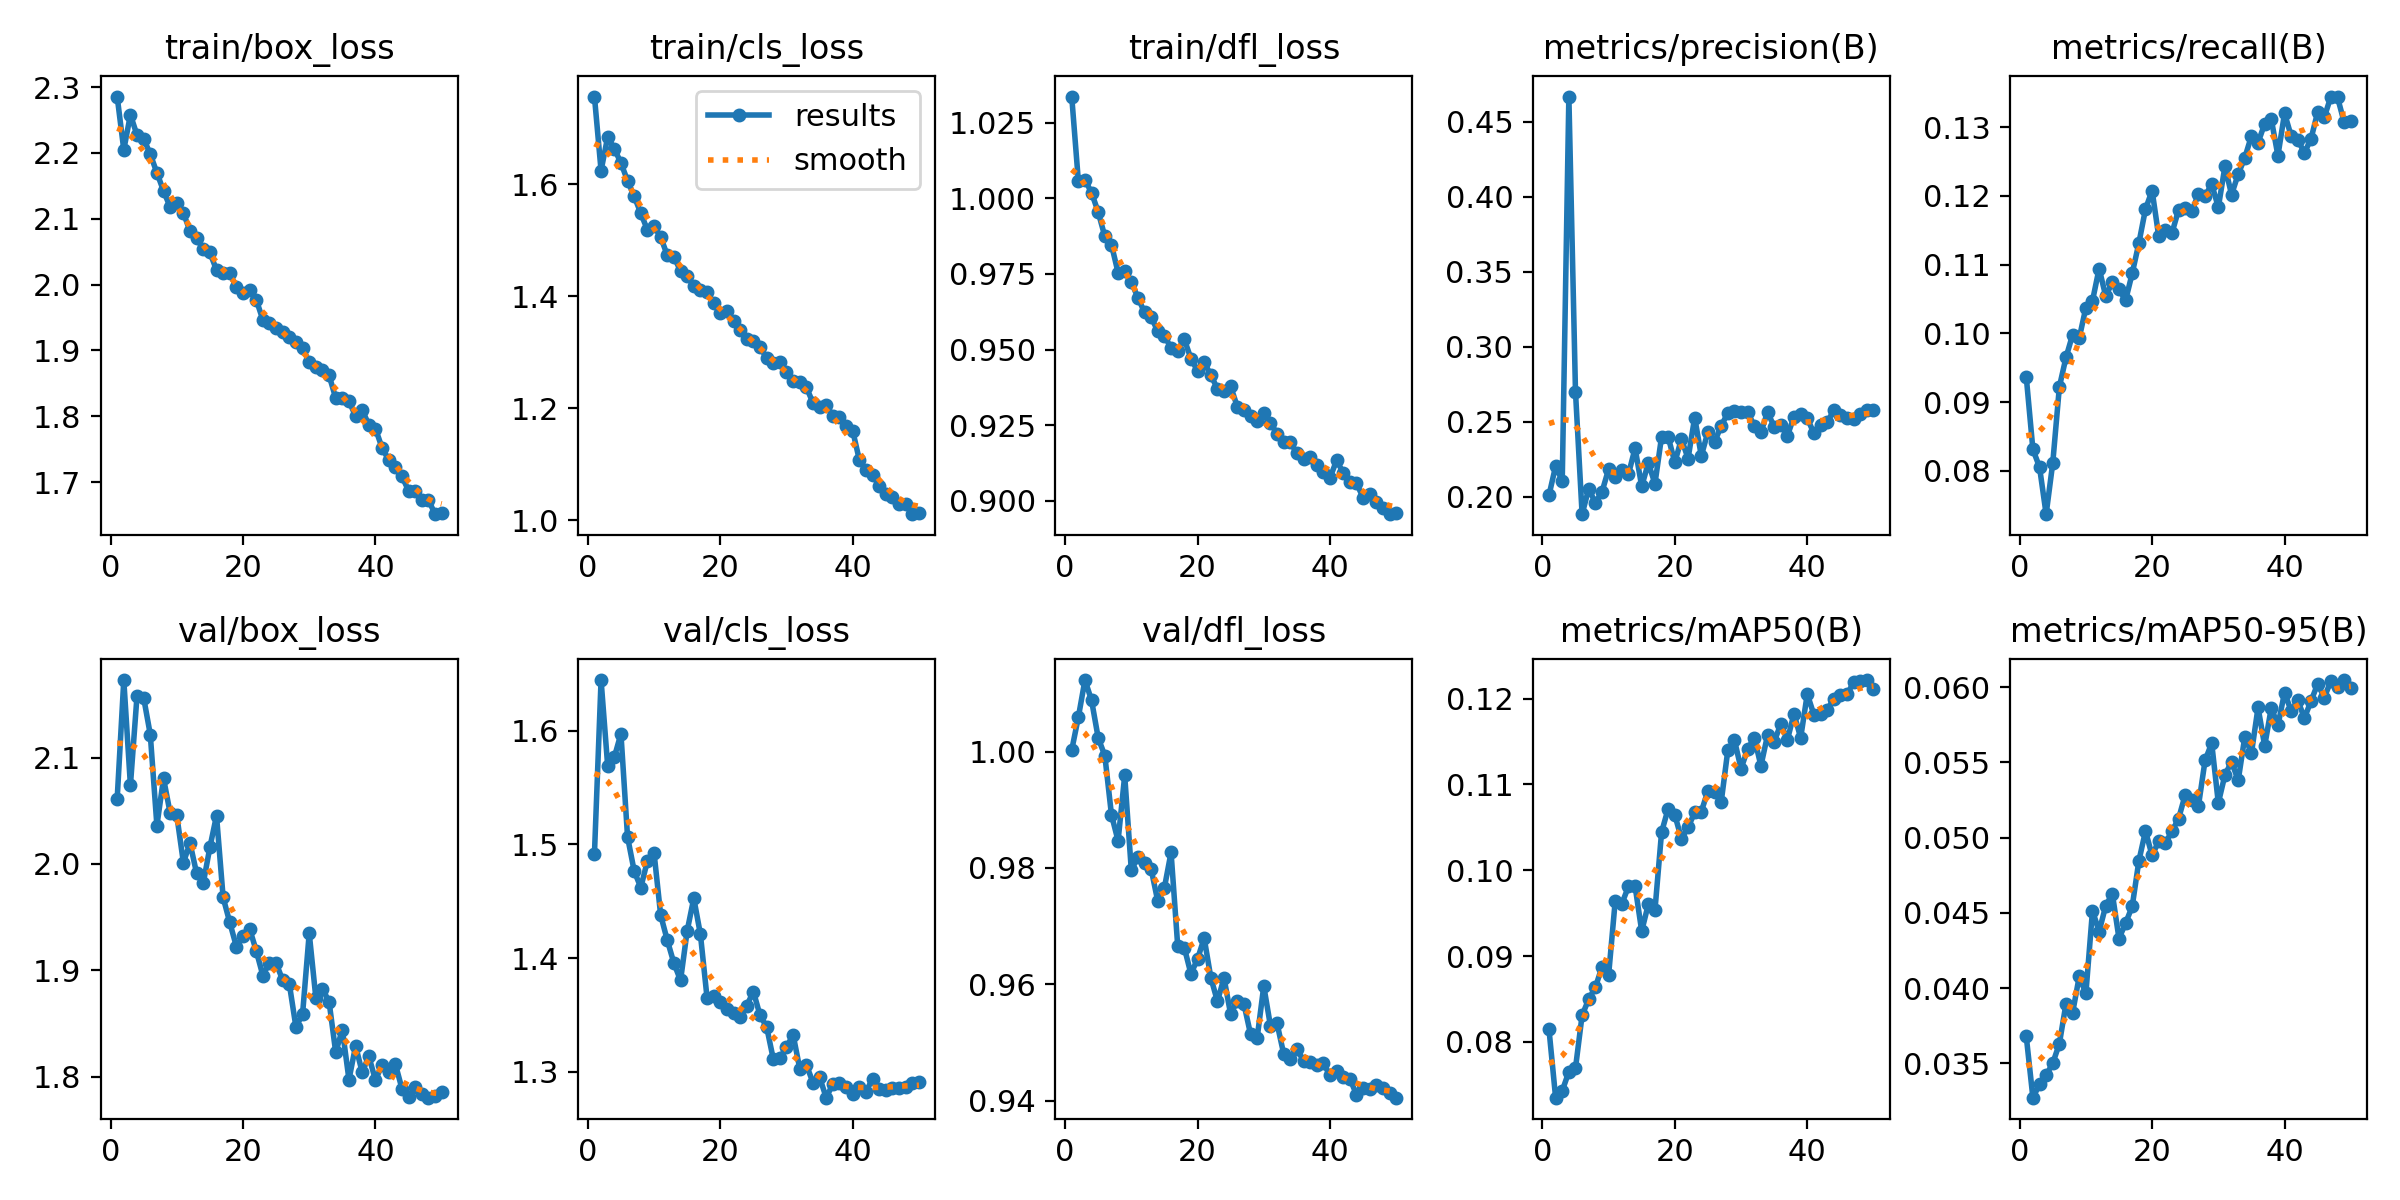


Your fine-tuned model is at: /content/runs/detect/finetune_visdrone_night_scaled/weights/best.pt


In [ ]:
# --- CELL 7: CHECK RESULTS (CORRECTED) ---

print("--- Training Results ---")
results_dir = '/content/runs/detect/finetune_visdrone_night_scaled'
print(f"Results are saved in: {results_dir}")
!ls -lh {results_dir}

# Display the results.png
results_png_path = os.path.join(results_dir, 'results.png')
if os.path.exists(results_png_path):
    print("\n--- Training Metrics (Loss, mAP) ---")

    # --- FIX ---
    # Use IpyImage (from IPython.display) instead of Image (from PIL)
    display(IpyImage(filename=results_png_path))
    # ---

else:
    print("results.png not found.")

print(f"\nYour fine-tuned model is at: {results_dir}/weights/best.pt")

Running inference on: /content/yolo_dataset/images/val/0000295_02900_d_0000034.jpg

image 1/1 /content/yolo_dataset/images/val/0000295_02900_d_0000034.jpg: 256x256 3 pedestrians, 37 vans, 2 awning-tricycles, 18.8ms
Speed: 0.5ms preprocess, 18.8ms inference, 1.3ms postprocess per image at shape (1, 3, 256, 256)
Results saved to /content/runs/detect/predict3

--- Detection Result (Boxes Only) ---


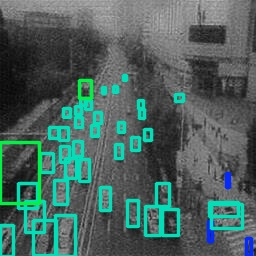

In [ ]:
# --- CELL 8: RUN INFERENCE (NO LABELS/CONF) ---

# 1. Load your newly fine-tuned model
model = YOLO('/content/runs/detect/finetune_visdrone_night_scaled/weights/best.pt')

# 2. Get a random image from your validation set
val_images = glob.glob('/content/yolo_dataset/images/val/*.jpg')
if val_images:
    test_image_path = val_images[0]
    print(f"Running inference on: {test_image_path}")

    # 3. Run prediction
    # --- FIX ---
    # Add show_labels=False and show_conf=False
    results = model.predict(
        test_image_path,
        save=True,
        conf=0.25,
        show_labels=False,  # <-- This hides the class name
        show_conf=False     # <-- This hides the confidence score
    )
    # ---

    # 4. Display the result
    print("\n--- Detection Result (Boxes Only) ---")

    # Get the first result object
    result = results[0]

    # Get the base filename from the original path
    base_filename = os.path.basename(result.path)

    # Create the new save path by joining the save_dir and the filename
    new_save_path = os.path.join(result.save_dir, base_filename)

    # Display the image from the correct path
    display(IpyImage(filename=new_save_path))

else:
    print("No validation images found to test on.")

In [ ]:
# --- CELL 9: PREDICT ON ALL VAL IMAGES (WITH LABELS) ---

print("Loading fine-tuned model...")
model = YOLO('/content/runs/detect/finetune_visdrone_night_scaled/weights/best.pt')

val_images_path = '/content/yolo_dataset/images/val/'
print(f"Running predictions on all images in: {val_images_path}")

# Run prediction on the entire validation folder
# This saves the results to 'runs/detect/predict' by default
results = model.predict(
    val_images_path,
    save=True,
    conf=0.25,
    project='runs/detect',
    name='predictions_with_labels', # Saves to 'runs/detect/predictions_with_labels'
    exist_ok=True,
    show_labels=True,  # Show labels and...
    show_conf=True     # Show confidence
)

print("\n✅ Complete. Predictions with labels saved to:")
print("/content/runs/detect/predictions_with_labels")

Loading fine-tuned model...
Running predictions on all images in: /content/yolo_dataset/images/val/

image 1/548 /content/yolo_dataset/images/val/0000001_02999_d_0000005.jpg: 256x256 11 vans, 1 bus, 1 motor, 18.8ms
image 2/548 /content/yolo_dataset/images/val/0000001_03499_d_0000006.jpg: 256x256 9 vans, 3 buss, 1 truck, 19.1ms
image 3/548 /content/yolo_dataset/images/val/0000001_03999_d_0000007.jpg: 256x256 3 vans, 18.8ms
image 4/548 /content/yolo_dataset/images/val/0000001_04527_d_0000008.jpg: 256x256 2 bicycles, 1 tricycle, 18.9ms
image 5/548 /content/yolo_dataset/images/val/0000001_05249_d_0000009.jpg: 256x256 59 vans, 1 bus, 18.9ms
image 6/548 /content/yolo_dataset/images/val/0000001_05499_d_0000010.jpg: 256x256 72 vans, 3 buss, 18.8ms
image 7/548 /content/yolo_dataset/images/val/0000001_05999_d_0000011.jpg: 256x256 1 pedestrian, 37 vans, 2 buss, 17.5ms
image 8/548 /content/yolo_dataset/images/val/0000001_07999_d_0000012.jpg: 256x256 1 pedestrian, 5 vans, 11.4ms
image 9/548 /conten

In [ ]:
# --- CELL 10: PREDICT ON ALL VAL IMAGES (BOXES ONLY) ---

print("Loading fine-tuned model...")
model = YOLO('/content/runs/detect/finetune_visdrone_night_scaled/weights/best.pt')

val_images_path = '/content/yolo_dataset/images/val/'
print(f"Running predictions (boxes only) on all images in: {val_images_path}")

# Run prediction on the entire validation folder
results = model.predict(
    val_images_path,
    save=True,
    conf=0.25,
    project='runs/detect',
    name='predictions_boxes_only', # Saves to 'runs/detect/predictions_boxes_only'
    exist_ok=True,
    show_labels=False, # <-- HIDE LABELS
    show_conf=False    # <-- HIDE CONFIDENCE
)

print("\n✅ Complete. Predictions (boxes only) saved to:")
print("/content/runs/detect/predictions_boxes_only")

Loading fine-tuned model...
Running predictions (boxes only) on all images in: /content/yolo_dataset/images/val/

image 1/548 /content/yolo_dataset/images/val/0000001_02999_d_0000005.jpg: 256x256 11 vans, 1 bus, 1 motor, 18.8ms
image 2/548 /content/yolo_dataset/images/val/0000001_03499_d_0000006.jpg: 256x256 9 vans, 3 buss, 1 truck, 19.0ms
image 3/548 /content/yolo_dataset/images/val/0000001_03999_d_0000007.jpg: 256x256 3 vans, 19.1ms
image 4/548 /content/yolo_dataset/images/val/0000001_04527_d_0000008.jpg: 256x256 2 bicycles, 1 tricycle, 18.9ms
image 5/548 /content/yolo_dataset/images/val/0000001_05249_d_0000009.jpg: 256x256 59 vans, 1 bus, 18.8ms
image 6/548 /content/yolo_dataset/images/val/0000001_05499_d_0000010.jpg: 256x256 72 vans, 3 buss, 19.3ms
image 7/548 /content/yolo_dataset/images/val/0000001_05999_d_0000011.jpg: 256x256 1 pedestrian, 37 vans, 2 buss, 19.7ms
image 8/548 /content/yolo_dataset/images/val/0000001_07999_d_0000012.jpg: 256x256 1 pedestrian, 5 vans, 18.8ms
image 

In [ ]:
# --- CELL 11: ZIP AND SAVE EVERYTHING TO DRIVE ---

import shutil

drive_save_path = '/content/drive/My Drive'
base_runs_dir = '/content/runs/detect'

# --- 1. Zip the Main Training Run (includes best.pt) ---
folder_to_zip = 'finetune_visdrone_night_scaled'
zip_name = 'finetune_visdrone_night_scaled_RUN'
print(f"Zipping {folder_to_zip}...")

shutil.make_archive(
    zip_name,
    'zip',
    root_dir=base_runs_dir,
    base_dir=folder_to_zip
)
print(f"✅ Created {zip_name}.zip")

# --- 2. Zip the Predictions (With Labels) ---
folder_to_zip = 'predictions_with_labels'
zip_name_labels = 'predictions_with_labels_IMAGES'
print(f"Zipping {folder_to_zip}...")

shutil.make_archive(
    zip_name_labels,
    'zip',
    root_dir=base_runs_dir,
    base_dir=folder_to_zip
)
print(f"✅ Created {zip_name_labels}.zip")

# --- 3. Zip the Predictions (Boxes Only) ---
folder_to_zip = 'predictions_boxes_only'
zip_name_boxes = 'predictions_boxes_only_IMAGES'
print(f"Zipping {folder_to_zip}...")

shutil.make_archive(
    zip_name_boxes,
    'zip',
    root_dir=base_runs_dir,
    base_dir=folder_to_zip
)
print(f"✅ Created {zip_name_boxes}.zip")

# --- 4. Move all three zip files to Google Drive ---
print(f"\nMoving all .zip files to {drive_save_path}...")
!mv /content/finetune_visdrone_night_scaled_RUN.zip "{drive_save_path}"
!mv /content/predictions_with_labels_IMAGES.zip "{drive_save_path}"
!mv /content/predictions_boxes_only_IMAGES.zip "{drive_save_path}"

print("---" * 20)
print("✅ ALL DONE. Your training run, model, and prediction images are saved to your Google Drive.")
print("---" * 20)

Zipping finetune_visdrone_night_scaled...
✅ Created finetune_visdrone_night_scaled_RUN.zip
Zipping predictions_with_labels...
✅ Created predictions_with_labels_IMAGES.zip
Zipping predictions_boxes_only...
✅ Created predictions_boxes_only_IMAGES.zip

Moving all .zip files to /content/drive/My Drive...
------------------------------------------------------------
✅ ALL DONE. Your training run, model, and prediction images are saved to your Google Drive.
------------------------------------------------------------
